# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
import pprint

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [5]:
azdias.shape

(891221, 85)

In [6]:
 t = azdias['CAMEO_DEU_2015']
 sum(pd.isnull(t))

98979

In [7]:
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [8]:
pd.set_option('display.max_columns',100)
azdias.describe(include='all')

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073,798073.000000,792242,792242,792242,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,10,45,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,8,6B,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,629528,NaN,134441,56672,133694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,NaN,4.052836,NaN,NaN,NaN,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699

In [9]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head(n=100)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#get total number of element
num_of_data = np.prod(azdias.shape)

In [12]:
#get percent of naturally missing elements in azdias
natural_miss_count = 0 #initialize counter

for i in azdias.count():
    natural_miss_count += i
    
percent_miss = 100*(1-natural_miss_count/num_of_data)

print("The percentage of naturally missing values is:", " ", percent_miss,"%", sep='')

The percentage of naturally missing values is: 6.46414961312%


In [13]:
for col in range(azdias.shape[1]):  #loop through azdias columns
    column_name = azdias.columns[col]  #get column name
    missing_list = feat_info.iloc[col,3]  #get missing_or_unknown column from data_dictionary
    missing_list = missing_list.replace('[','') #remove left bracket from string
    missing_list = missing_list.replace(']','') #remove right bracket from string
    missing_list = missing_list.split(',')  #split into individual strings
    
    #find data that is natually missing and continue loop to omit
    if missing_list == ['']:
        continue
        
    else:
        for dat_type in missing_list:  
            if azdias[column_name].dtype == 'object': #find values that contain x
                azdias.loc[azdias[column_name] == dat_type, column_name] = np.nan #replace x with nan
               
            else:
                dat_type = int(dat_type) #if no x, convert to integer and replace with nan
                azdias.loc[azdias[column_name] == dat_type, column_name] = np.nan
                
azdias.head(n=20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,NaN,2.0,5.0,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,NaN,1.0,5.0,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,NaN,1.0,3.0,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,NaN,2.0,4.0,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,0.0,0.0,NaN,2.0,4.0,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2.0,5.0,1.0,5.0,1.0,5.0,4.0,3.0,4.0,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2.0,5.0,5.0,7.0,2.0,6.0,5.0,5.0,7.0,7.0,4.0,7.0,7.0,7.0,1.0,0.0,NaN,1.0,4.0,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1.0,3.0,3.0,3.0,4.0,1.0,3.0,2.0,5.0,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7.0,7.0,7.0,5.0,6.0,2.0,2.0,7.0,5.0,1.0,1.0,2.0,5.0,5.0,0.0,0.0,NaN,1.0,1.0,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,6.0,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4.0,5.0,4.0,1.0,5.0,6.0,4.0,5.0,2.0,5.0,5.0,3.0,1.0,4

In [14]:
#find number of unknown or missing elements
code_miss_count = azdias.isnull().sum().sum()

print("The percentage of missing or unknown values is:", " ", (100*(code_miss_count/num_of_data)),"%", sep='')

The percentage of missing or unknown values is: 11.054139407%


In [15]:
azdias.describe() 

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,498903.000000,886367.000000,891221.000000,780025.000000,793589.000000,796649.000000,813429.000000,813429.000000,886367.000000,886367.000000,782906.000000,783057.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,780025.000000,817722.000000,2160.000000,780025.000000,891221.000000,580954.000000,817722.000000,817722.000000,872873.000000,306609.000000,743233.000000,817722.000000,791610.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,414697.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,733157.000000,757897.000000,886367.000000,733157.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1967.102689,7.350304,0.196612,2.190129,16.332161,4.955185,3.922339,2.381976,4.791151,2.432575,1.168889,9.280709,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.590134,0.008423,1.318519,1.511166,3.362438,15.291805,1.727637,0.004162,4.207243,3.410640,4.147141,7.908791,8.354924,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,2.539534,3.158580,4.153043,3.939172,4.549491,3.738306,2.723384,2.963540,2.698691,4.472086,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,17.795208,3.525723,0.397437,0.755213,12.242378,3.748974,3.941285,1.701527,3.425305,1.474315,0.475075,4.032107,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.027972,0.091392,0.999504,0.499876,1.352704,3.800536,1.155849,0.068855,1.624057,1.628844,1.784211,1.923137,15.673731,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.693151,1.329537,2.183710,1.718996,2.028919,0.923193,0.979867,1.428882,1.521524,1.836357,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

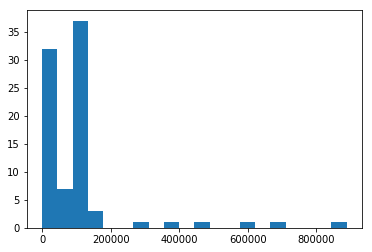

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

count_miss = azdias.isnull().sum(axis=0).values #find number of nans for each column
count_miss = [val for val in count_miss]
plt.hist(count_miss, bins=20)
plt.show()

In [17]:
# Investigate patterns in the amount of missing data in each column.

#Show stats for entire dataframe
pd.DataFrame({'stat':count_miss}).describe()

,stat
count,85.000000
mean,98516.811765
std,146604.203317
min,0.000000
25%,0.000000
50%,93148.000000
75%,116515.000000
max,889061.000000


In [18]:
#Show number of missing data in each column
pd.set_option('display.max_rows',100)
azdias.isnull().sum(axis=0) 

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

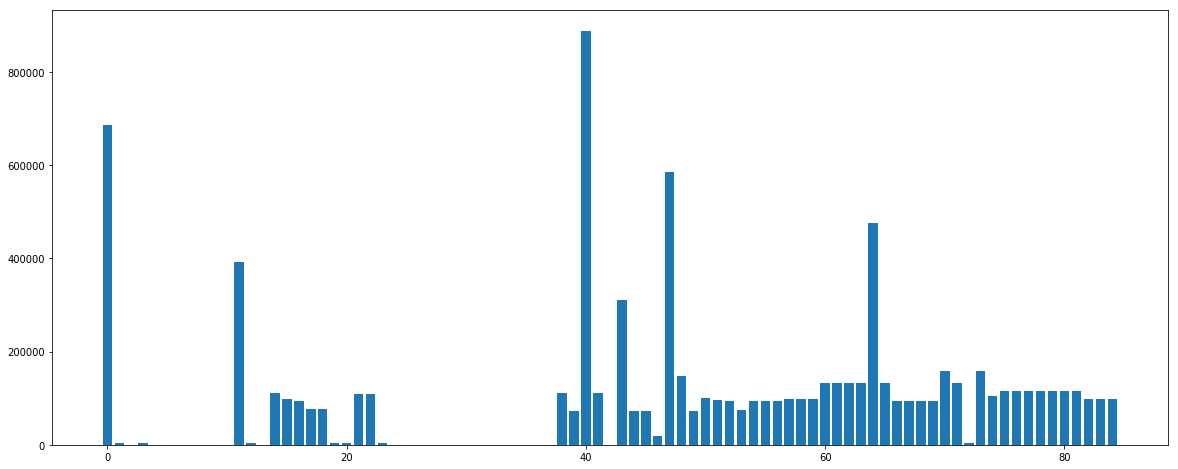

In [19]:
#plot number of missing values per column

plt.figure(figsize=(20,8))
x = range(0,azdias.shape[1])
plt.bar(x,count_miss)
plt.show()

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#Remove columns with more than 200,000 missing values
drop_cols = []

for ind, val in enumerate(count_miss):
    if val > 200000:
        drop_cols.append(ind)
        
azdias_drop_cols = list(azdias.columns[drop_cols])
azdias = azdias.drop(azdias_drop_cols, axis=1)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,3.0,1.0,2.0,5.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,2.0,0.0,1.0,5.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,2.0,0.0,2.0,4.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

The percentage of missing data that is naturally missing is 6.46% and the percent of missing or unknown values is 11.05%. According to the histogram plot, there are a few columns which contain significantly more missing data than the other columns and so those columns were removed. Columns that were missing greater than 200,000 data points were chosen to be removed. Those columns which were removed are:
AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

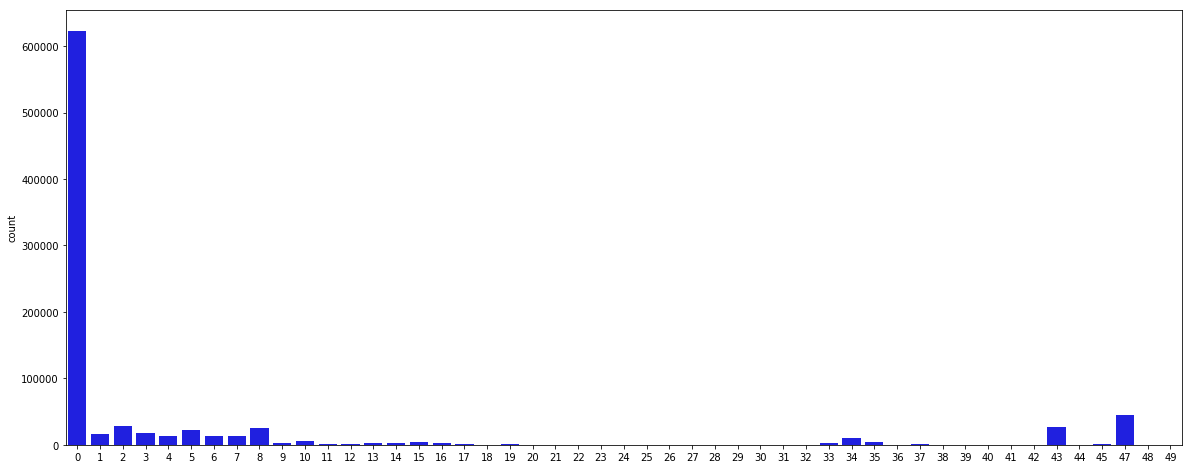

In [21]:
# How much data is missing in each row of the dataset?
count_miss_row = azdias.isnull().sum(axis = 1).values
plt.figure(figsize = (20,8))
ax = sns.countplot(count_miss_row, color = 'blue')
plt.show()

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Divide the data using threshold of defined variable threshold
threshold = 10 #define threshold value
azdias_sub1 = azdias.loc[count_miss_row <= threshold]
azdias_sub2 = azdias.loc[count_miss_row > threshold]

print(azdias_sub1.shape)
print(azdias_sub2.shape)

(780153, 79)
(111068, 79)


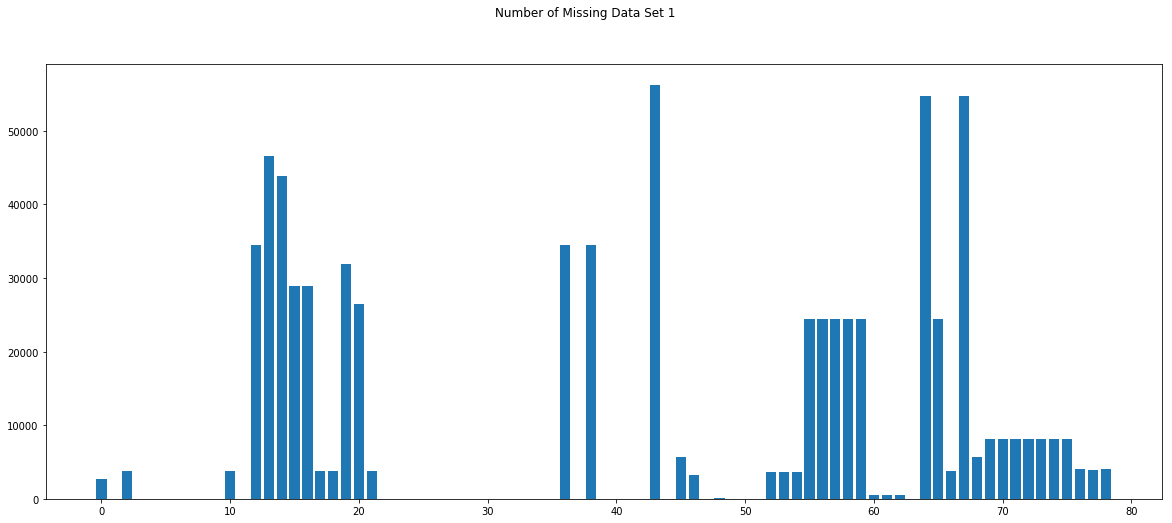

In [83]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

count_miss_sub1_col = azdias_sub1.isnull().sum(axis = 0).values #sum number of missing values for each column

plt.figure(figsize=(20,8))
x = range(0,count_miss_sub1_col.shape[0])
plt.suptitle('Number of Missing Data Set 1')
plt.bar(x,count_miss_sub1_col)
plt.show()

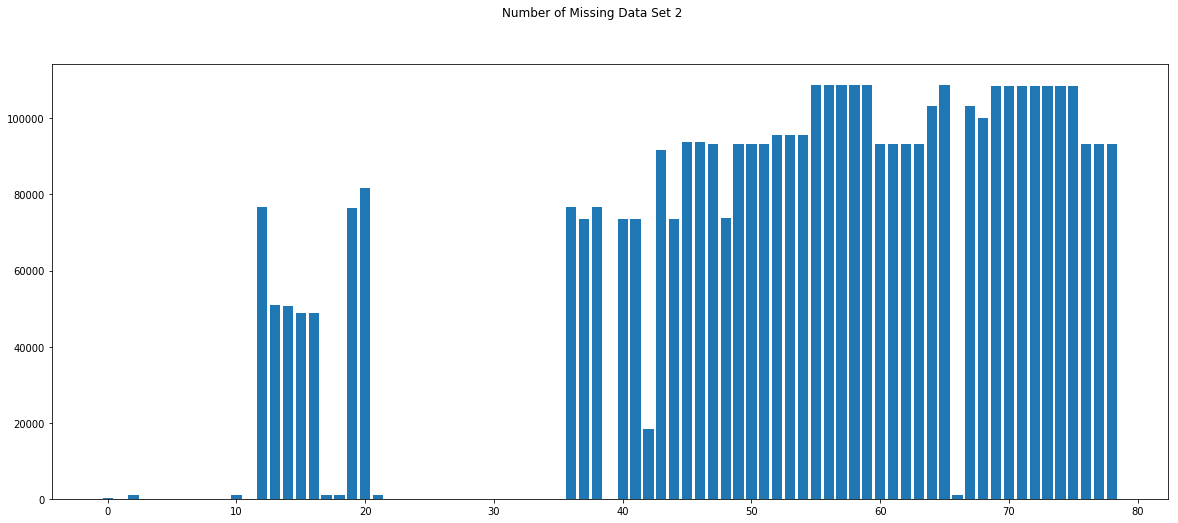

In [84]:
count_miss_sub2_col = azdias_sub2.isnull().sum(axis = 0).values #sum number of missing values for each column

plt.figure(figsize=(20,8))
x = range(0,count_miss_sub2_col.shape[0])
plt.suptitle('Number of Missing Data Set 2')
plt.bar(x,count_miss_sub2_col)
plt.show()

In [25]:
# Use columns 5,10,15,20,25
res_col = [5,10,15,20,25]
azdias_sub1_plot = azdias_sub1.iloc[:,res_col]
azdias_sub2_plot = azdias_sub2.iloc[:,res_col]

In [26]:
def subset_plot(ind):
    st_title = 'Column '+str(azdias_sub1_plot.columns[ind-1])+' distribution between sets 1 and 2'
    plt.suptitle(st_title)
    plt.subplot(121)
    plt.subplots_adjust(right=3, wspace=.2)
    sns.countplot(azdias_sub1_plot.iloc[:,ind - 1].values,color='blue')
    plt.subplot(122)
    sns.countplot(azdias_sub2_plot.iloc[:,ind - 1].values,color='blue')

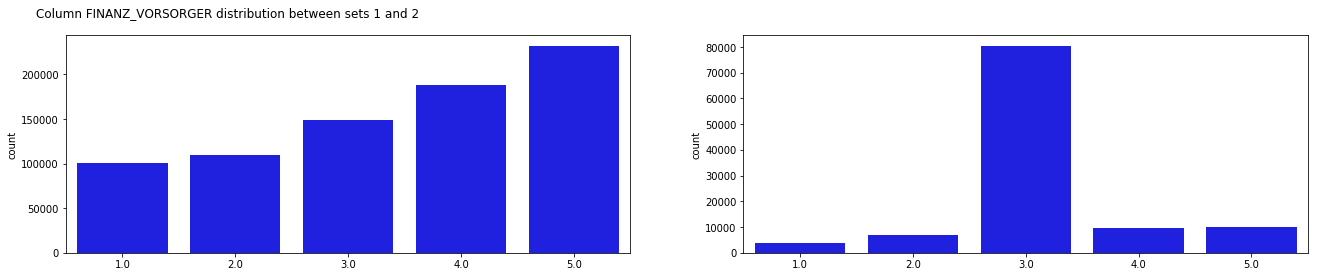

In [27]:
subset_plot(1)

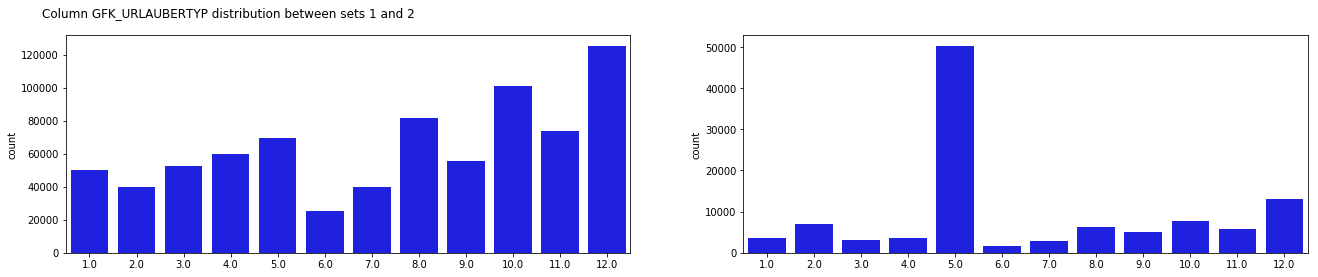

In [28]:
subset_plot(2)

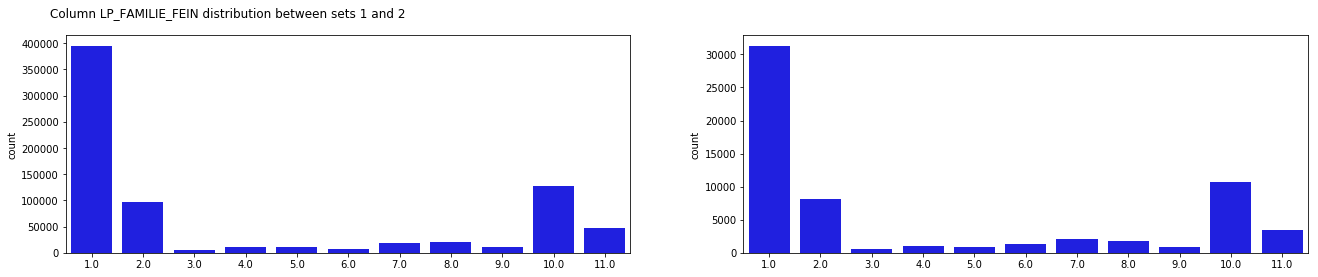

In [29]:
subset_plot(3)

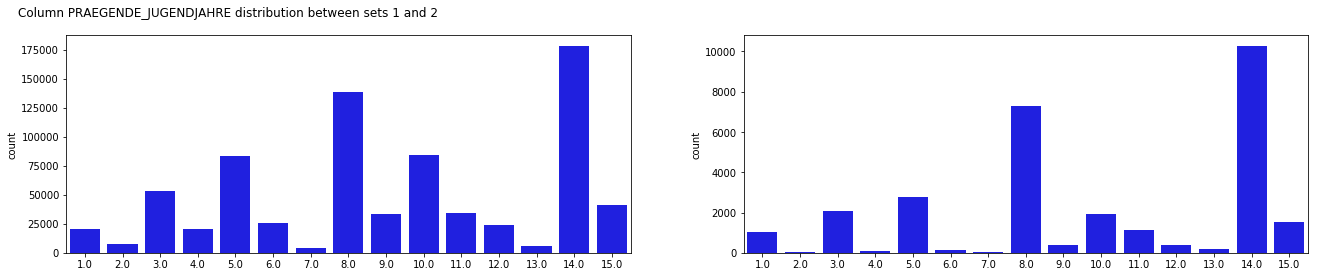

In [30]:
subset_plot(4)

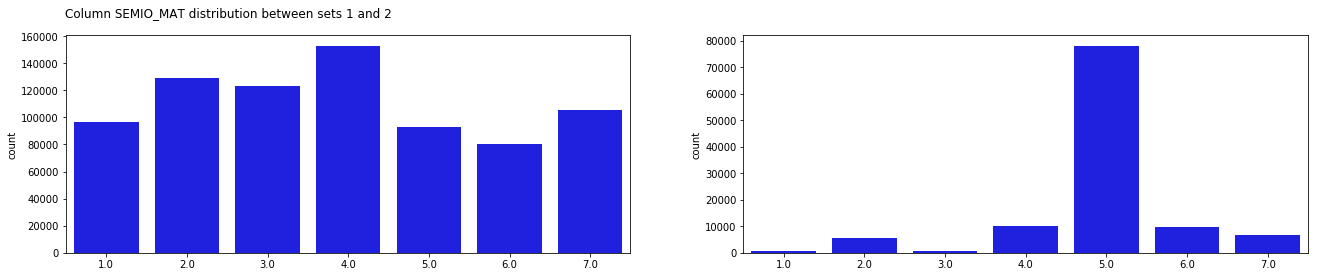

In [31]:
subset_plot(5)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The second subset has much more missing data per column compared to the first subset. 
The rows seem to have much less missing data.
There does seem to be a quantitive difference between the data with few or no missing values based on the subset plots.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?

feat_info.groupby(['type']).size()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [33]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#show only categorical type columns
feat_info[feat_info['type'] == 'categorical']


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.

#get list of attributes with type categorical
cat_cols = [] #initialize
for i in feat_info[feat_info['type'] == 'categorical']['attribute']:
    cat_cols.append(i)

In [35]:
#Look for one binary variable taking non-numeric and create dummy variable, and look for multi-level categoricals
#and drop if found

for cols in azdias.columns:
    if cols in cat_cols:
        if len(azdias[cols].unique()) > 2: #if the length of number of unique values is greater than 2 
            azdias = azdias.drop(cols, axis=1) #drop from the analysis
            print("more than 2 categories: {}".format(cols))
            
        else:
            if not azdias[cols].unique()[0] > 0:
                dummies = pd.get_dummies(azdias[cols], prefix=cols)
                azdias = azdias.drop(cols, axis=1) #create dummy variable
                azdias = azdias.join(dummies)
                print("transformed to dummy variable: {}".format(cols))

more than 2 categories: CJT_GESAMTTYP
more than 2 categories: FINANZTYP
more than 2 categories: GFK_URLAUBERTYP
transformed to dummy variable: GREEN_AVANTGARDE
more than 2 categories: LP_FAMILIE_FEIN
more than 2 categories: LP_FAMILIE_GROB
more than 2 categories: LP_STATUS_FEIN
more than 2 categories: LP_STATUS_GROB
more than 2 categories: NATIONALITAET_KZ
more than 2 categories: SHOPPER_TYP
more than 2 categories: SOHO_KZ
more than 2 categories: VERS_TYP
more than 2 categories: ZABEOTYP
more than 2 categories: GEBAEUDETYP
more than 2 categories: OST_WEST_KZ
more than 2 categories: CAMEO_DEUG_2015
more than 2 categories: CAMEO_DEU_2015


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

feat_info has 21 features classified as type categorical. By re-encoding the features, feat_info was decreased to 17 features due to multi-level categoricals being dropped. There was only 1 feature to be set as a dummy variable by one hot encoding, GREEN_AVANTGARDE.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info[feat_info['type'] == 'mixed']

azdias['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [37]:
# create variable: MOVEMENT
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MOVEMENT'] = 1
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MOVEMENT'] = 2

In [38]:
#create variable Decade
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'DECADE'] = 40
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'DECADE'] = 50
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'DECADE'] = 60
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'DECADE'] = 70
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'DECADE'] = 80
azdias.loc[azdias['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'DECADE'] = 90

In [39]:
# drop PRAEGENDE_JUGENDJAHRE column
azdias=azdias.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,MOVEMENT,DECADE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,NaN,15.0,4.0,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,1.0,90.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,2.0,90.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,NaN,NaN,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,1.0,70.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,1.0,70.0


In [40]:
# Investigate "CAMEO_INTL_2015" and create two new variables: WEALTH and LIFE_STAGE.

feat_info[feat_info['type'] == 'mixed']

azdias['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [41]:
azdias['CAMEO_INTL_2015']=azdias['CAMEO_INTL_2015'].astype(float)

# create new variable: WEALTH
azdias.loc[azdias['CAMEO_INTL_2015'].isin([51,52,53,54,55]), 'WEALTH'] = 1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([41,42,43,44,45]), 'WEALTH'] = 2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([31,32,33,34,35]), 'WEALTH'] = 3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([21,22,23,24,25]), 'WEALTH'] = 4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,12,13,14,15]), 'WEALTH'] = 5

In [42]:
# create new variable: LIFE_STAGE
azdias.loc[azdias['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE'] = 1
azdias.loc[azdias['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE'] = 2
azdias.loc[azdias['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE'] = 3
azdias.loc[azdias['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE'] = 4
azdias.loc[azdias['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE'] = 5

In [43]:
# drop original column
azdias = azdias.drop('CAMEO_INTL_2015',axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,NaN,15.0,4.0,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,1.0,90.0,1.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,2.0,90.0,4.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,NaN,NaN,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,1.0,70.0,5.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,1.0,70.0,2.0,3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the PRAEGENDE_JUGENDJAHRE feature, two variables (MOVEMENT and DECADE) were created from the original PRAEGENDE_JUGENDJAHRE column based on Data_Dictionary.md. The PRAEGENDE_JUGENDJAHRE feature was then dropped from the dataframe.

For the CAMEO_INTL_2015 feature, two variables (WEALTH and LIFE_STAGE) were created from the original CAMEO_INTL_2015 column based on Data_Dictionary.md. The CAMEO_INTL_2015 feature was then dropped from the dataframe.

Features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB were removed as their information is already described in other variablesand so the information is redundant.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Remove mixed categorical variables
azdias = azdias.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'],axis=1)

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GREEN_AVANTGARDE_0,GREEN_AVANTGARDE_1,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,2.0,1.0,3.0,4.0,3.0,5.0,5.0,3.0,NaN,5.0,2.0,6.0,7.0,5.0,1.0,5.0,3.0,3.0,4.0,7.0,6.0,6.0,5.0,3.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1,0,1.0,90.0,1.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,1,2.0,90.0,4.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1,0,1.0,70.0,5.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1,0,1.0,70.0,2.0,3.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in range(df.shape[1]):  #loop through azdias columns
        column_name = df.columns[col]  #get column name
        missing_list = feat_info.iloc[col,3]  #get missing_or_unknown column from data_dictionary
        missing_list = missing_list.replace('[','') #remove left bracket from string
        missing_list = missing_list.replace(']','') #remove right bracket from string
        missing_list = missing_list.split(',')  #split into individual strings
    
        #find data that is natually missing and continue loop to omit
        if missing_list == ['']:
            continue
        
        else:
            for dat_type in missing_list:  
                if df[column_name].dtype == 'object': #find values that contain x
                    df.loc[df[column_name] == dat_type, column_name] = np.nan #replace x with nan
               
                else:
                    dat_type = int(dat_type) #if no x, convert to integer and replace with nan
                    df.loc[df[column_name] == dat_type, column_name] = np.nan
    
    # select, re-encode, and engineer column values.
    for cols in df.columns:
        if cols in cat_cols:
            if len(df[cols].unique()) > 2: #if the length of number of unique values is greater than 2 
                df = df.drop(cols, axis=1) #drop from the analysis
                print("more than 2 categories: {}".format(cols))
            
            else:
                if not df[cols].unique()[0] > 0:
                    dummies = pd.get_dummies(df[cols], prefix=cols)
                    df = df.drop(cols, axis=1) #create dummy variable
                    df = df.join(dummies)
    
    # create variable: MOVEMENT
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'MOVEMENT'] = 1
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'MOVEMENT'] = 2
    
    #Capture Decade
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([1,2]), 'DECADE'] = 40
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([3,4]), 'DECADE'] = 50
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([5,6,7]), 'DECADE'] = 60
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([8,9]), 'DECADE'] = 70
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([10,11,12,13]), 'DECADE'] = 80
    df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([14,15]), 'DECADE'] = 90
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)

    # create new variable: WEALTH
    df.loc[df['CAMEO_INTL_2015'].isin([51,52,53,54,55]), 'WEALTH'] = 1
    df.loc[df['CAMEO_INTL_2015'].isin([41,42,43,44,45]), 'WEALTH'] = 2
    df.loc[df['CAMEO_INTL_2015'].isin([31,32,33,34,35]), 'WEALTH'] = 3
    df.loc[df['CAMEO_INTL_2015'].isin([21,22,23,24,25]), 'WEALTH'] = 4
    df.loc[df['CAMEO_INTL_2015'].isin([11,12,13,14,15]), 'WEALTH'] = 5
    
    # create new variable: LIFE_STAGE
    df.loc[df['CAMEO_INTL_2015'].isin([11,21,31,41,51]),'LIFE_STAGE'] = 1
    df.loc[df['CAMEO_INTL_2015'].isin([12,22,32,42,52]),'LIFE_STAGE'] = 2
    df.loc[df['CAMEO_INTL_2015'].isin([13,23,33,43,53]),'LIFE_STAGE'] = 3
    df.loc[df['CAMEO_INTL_2015'].isin([14,24,34,44,54]),'LIFE_STAGE'] = 4
    df.loc[df['CAMEO_INTL_2015'].isin([15,25,35,45,55]),'LIFE_STAGE'] = 5
    
    # remove selected columns and rows, ...
    df = df.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
    df = df.drop('CAMEO_INTL_2015',axis=1)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = Imputer(missing_values=np.nan, strategy="median", axis=1) #create imputed variable
azdias_imp = pd.DataFrame(imp.fit_transform(azdias)) #apply imputer function to azdias dataframe and 
#store in new dataframe

azdias_imp.columns = azdias.columns #copy columns from azdias dataframe to imputed dataframe

In [48]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imp.values) #standardize features by removing the mean and scaling to unit
#variance

### Discussion 2.1: Apply Feature Scaling

An imputer was applied to replace all the missing values in the azdias dataframe. Then, each feature was scaled to mean 0 and standard deviation 1 by applying the StandardScaler function.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca = PCA()
az_pca = pca.fit(azdias_scaled)

In [50]:
# Investigate the variance accounted for by each principal component.

In [51]:
#create scree plot 
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

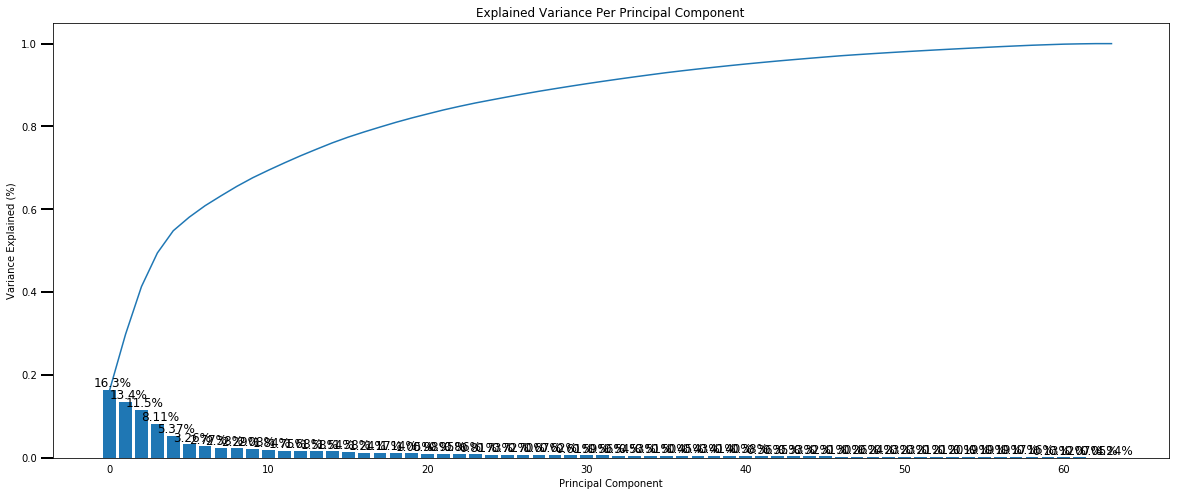

In [52]:
scree_plot(az_pca)

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 50)
az_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Based on the scree plot function (provided in the course), choosing a principal component value of 50 yields an explained variance close to 0 so 50 components will be retained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#define function that takes a principal component value and creates a sorted dictionary of principal 
#component mapped to corresponding feature name
def weights(princ_comp):
    weight_dict = {}
    
    ident_mat = np.identity(azdias_scaled.shape[1])  #create identity matrix
    coef = pca.transform(ident_mat) #apply pca transformation on the identity matrix
    
    j=0
    for col in azdias.columns:
        weight_dict.update({col: coef[j][princ_comp]})  #create dictionary for each feature and associated component
        j += 1
        
    sorted_dict = sorted(weight_dict, key=weight_dict.get) #sort weighted dictionary in ascending order
    
    for item in sorted_dict:
        print(item,":", " ", weight_dict[item], sep='')

In [55]:
#pass defined principal component to weights function
pc = 0
weights(pc)

FINANZ_MINIMALIST: -0.196537043806
MOBI_REGIO: -0.190111363414
KBA05_GBZ: -0.175288021789
INNENSTADT: -0.170190710222
PLZ8_GBZ: -0.154616934861
WEALTH: -0.151433229343
MIN_GEBAEUDEJAHR: -0.149970607475
ALTERSKATEGORIE_GROB: -0.141283293583
KONSUMNAEHE: -0.138621640675
KBA13_ANZAHL_PKW: -0.138399209105
WOHNDAUER_2008: -0.137745896869
PLZ8_ANTG1: -0.133488817072
FINANZ_VORSORGER: -0.133239959237
BALLRAUM: -0.130965711896
GEBAEUDETYP_RASTER: -0.129714938653
KBA05_ANTG1: -0.114921378403
SEMIO_VERT: -0.113446280484
GREEN_AVANTGARDE_1: -0.111745515318
SEMIO_ERL: -0.102796679581
LIFE_STAGE: -0.0978890510038
WOHNLAGE: -0.0977962545322
SEMIO_LUST: -0.0681497248749
DECADE: -0.0666548366278
RETOURTYP_BK_S: -0.0384612522324
SEMIO_SOZ: -0.0286638363346
ONLINE_AFFINITAET: -0.0281649070432
W_KEIT_KIND_HH: -0.0192106867546
ANZ_PERSONEN: -0.0083190169367
PLZ8_HHZ: 0.00222696398735
REGIOTYP: 0.0245194283766
SEMIO_KULT: 0.0294368312636
ANREDE_KZ: 0.0294752469665
KKK: 0.0440266472193
MOVEMENT: 0.072901970

In [56]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc = 1
weights(pc)

KBA05_ANTG1: -0.237215881575
PLZ8_ANTG1: -0.226737519358
ANZ_TITEL: -0.21339193341
ANZ_HH_TITEL: -0.197203322618
FINANZ_UNAUFFAELLIGER: -0.189823878962
MOBI_REGIO: -0.187239978559
MOVEMENT: -0.185191837245
FINANZ_ANLEGER: -0.181797591878
WEALTH: -0.179758851129
KBA05_GBZ: -0.159929466226
SEMIO_REL: -0.142893534648
ANZ_PERSONEN: -0.142802270041
KONSUMNAEHE: -0.132296316606
KBA05_ANTG4: -0.124371204585
FINANZ_SPARER: -0.112120634561
KBA05_ANTG2: -0.107207825176
ONLINE_AFFINITAET: -0.104553436654
PLZ8_GBZ: -0.103555946198
SEMIO_PFLICHT: -0.0979566159234
LIFE_STAGE: -0.0852624462787
SEMIO_RAT: -0.085151587821
HEALTH_TYP: -0.0814734909653
SEMIO_KRIT: -0.0808518507491
KBA05_ANTG3: -0.0787682567279
INNENSTADT: -0.0773337474481
SEMIO_MAT: -0.0740962920335
BALLRAUM: -0.066988194719
SEMIO_FAM: -0.0651338961129
FINANZ_MINIMALIST: -0.0604503274121
SEMIO_DOM: -0.0592134223708
SEMIO_TRADV: -0.0573857661452
PLZ8_ANTG4: -0.0541486906833
SEMIO_KAEM: -0.0454795750907
WOHNLAGE: -0.035841490643
GEBAEUDETY

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc = 2
weights(pc)

SEMIO_KULT: -0.302371550766
SEMIO_TRADV: -0.233505886702
DECADE: -0.23126087287
SEMIO_SOZ: -0.210105678697
SEMIO_FAM: -0.20366284493
SEMIO_PFLICHT: -0.196771527667
SEMIO_REL: -0.194948044672
SEMIO_VERT: -0.181095858837
FINANZ_SPARER: -0.180694127275
SEMIO_MAT: -0.152579923121
MIN_GEBAEUDEJAHR: -0.13752560799
ONLINE_AFFINITAET: -0.127006080541
SEMIO_RAT: -0.12133258022
FINANZ_UNAUFFAELLIGER: -0.105948870994
FINANZ_ANLEGER: -0.0891042919474
KBA13_ANZAHL_PKW: -0.0862826793361
HH_EINKOMMEN_SCORE: -0.0681429631505
INNENSTADT: -0.0574754081419
WOHNLAGE: -0.0565398976913
BALLRAUM: -0.0458076774486
GEBAEUDETYP_RASTER: -0.0403654980741
WOHNDAUER_2008: -0.0373841510808
PLZ8_GBZ: -0.0369676092332
REGIOTYP: -0.0357470749444
PLZ8_HHZ: -0.0302677720918
KBA05_GBZ: -0.0220810758246
KONSUMNAEHE: -0.0174838995183
ORTSGR_KLS9: -0.0102062716386
MOBI_REGIO: -0.00925778986148
HEALTH_TYP: -0.00868226622132
GREEN_AVANTGARDE_1: -0.00775759404353
KKK: -0.00302199367114
ANZ_HAUSHALTE_AKTIV: -0.000393927249982
GR

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The first principal component is most positively impacted by the features PLZ8_ANTG3, PLZ8_BAUMAX, and PLZ8_ANTG4 and most negatively impacted by the features FINANZ_MINIMALIST, MOBI_REGIO, KBA05_GBZ. The PLZ features are housing related and the FINANZ, MOBI, and KBA05 features are finance related. It makes sense that they would be related positively and negatively. 

The second principal component is most positively impacted by the features ORTSGR_KLS9, MIN_GEBAEUDEJAHR, and HH_EINKOMMEN_SCORE, and most negatively impacted by the features KBA05_ANTG1, PLZ8_ANTG1, ANZ_TITEL. 

KBA05_ANTG1 and PLZ8_ANTG1 are family housing related, and AN_TITEL is the number of professional academic title holders per household. 

ORTSGR_KLS9 is the size of community, MIN_GEBAEUDEJAHR is the first year building was mentioned in database, and HH_EINKOMMEN_SCORE is the estimated household net income.

It seems that higher income earners could be living in larger, newer communities which could negatively impact number of housing.

The third principal component is most positively impacted by the features SEMIO_KRIT, ALTERSKATEGORIE_GROB, and SEMIO_ERL and most negatively impacted by the features 

SEMIO_KRIT are critically-minded individuals, ALTERSKATEGORIE_GROB is the person's estimated age, and SEMIO_ERL are event-oriented individuals SEMIO_KULT, SEMIO_TRADV, and DECADE.

SEMIO_KULT are cultural-minded individuals, SEMIO_TRADV are traditional-minded individuals, and DECADE is the feature defined above as generation defined by decade.

It seems that a person's age will have an impact as to individuals topology.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [60]:
# Over a number of different cluster counts...
scores = []
centers = list(range(1,30))

    # run k-means clustering on the data and...
for center in centers:
    scores.append(get_kmeans_score(az_pca, center))  # compute the average within cluster distances

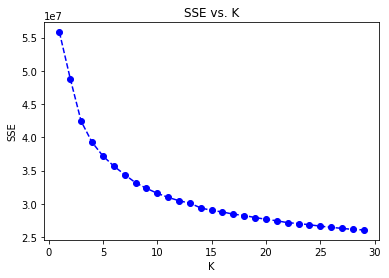

In [61]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

#refit kmeans using 12 clusters
kmeans = KMeans(n_clusters = 12)
model = kmeans.fit(az_pca)

pred_pop = model.predict(az_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I decided that based on visual observation of the SSE vs K plot that 12 clusters seems appropriate to segment the population utilizing 30 cluster counts. This was chosen as I felt that is where the elbow is located.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [63]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers)
nan_customers = pd.DataFrame(customers.shape[1] - customers.count(axis=1))

more than 2 categories: AGER_TYP
more than 2 categories: CJT_GESAMTTYP
more than 2 categories: FINANZTYP
more than 2 categories: GFK_URLAUBERTYP
more than 2 categories: LP_FAMILIE_FEIN
more than 2 categories: LP_FAMILIE_GROB
more than 2 categories: LP_STATUS_FEIN
more than 2 categories: LP_STATUS_GROB
more than 2 categories: NATIONALITAET_KZ
more than 2 categories: SHOPPER_TYP
more than 2 categories: SOHO_KZ
more than 2 categories: TITEL_KZ
more than 2 categories: VERS_TYP
more than 2 categories: ZABEOTYP
more than 2 categories: KK_KUNDENTYP
more than 2 categories: GEBAEUDETYP
more than 2 categories: OST_WEST_KZ
more than 2 categories: CAMEO_DEUG_2015
more than 2 categories: CAMEO_DEU_2015


In [65]:
#run imputer
imp_cust = Imputer(missing_values=np.nan, strategy="median", axis=1) #create imputed variable
cust_imp = pd.DataFrame(imp_cust.fit_transform(customers)) #apply imputer function to customers dataframe and 
#store in new dataframe

cust_imp.columns = customers.columns #copy columns from customers dataframe to imputed dataframe

In [66]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
cust_scaled = scaler.fit_transform(cust_imp.values) #standardize features by removing the mean and scaling to unit
#variance

#apply PCA to the data
cust_pca = pca.fit_transform(cust_scaled)

#apply k-means clustering to the data
cust_model = kmeans.fit(cust_pca)

pred_cust = cust_model.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [67]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [68]:
#Calculate the proportion of each cluster to the whole population and store in population dictionary
az_bin = np.bincount(pred_pop) #use bincount to get number of non-negative values

az_dict = {}
for p in range(len(az_bin)): #loop over number of clusters
    az_dict[p] = az_bin[p] * 100/len(azdias) #calculate percent of each cluster to the whole population

In [69]:
pprint.pprint(az_dict)

{0: 9.4524253804611877,
 1: 11.138987972680177,
 2: 6.7340199568906032,
 3: 3.2489135691371724,
 4: 9.3599679540764864,
 5: 8.3080403177214173,
 6: 10.333912688323098,
 7: 7.0082504788374598,
 8: 6.679600233836501,
 9: 6.9429468111725372,
 10: 9.8917103614030637,
 11: 10.901224275460295}


In [70]:
#Calculate the proportion of each cluster to the number of customers and store in customer dictionary
cust_bin = np.bincount(pred_cust)  #use bincount to get number of non-negative values

cust_dict={}
for q in range(len(cust_bin)):  #loop over number of clusters
    cust_dict[q] = cust_bin[q] * 100/len(customers)  #Calculate the percent of each cluster to the number of customers

In [71]:
pprint.pprint(cust_dict)

{0: 5.5125957464571202,
 1: 7.0252332352388702,
 2: 7.6821530691044186,
 3: 2.3553106672510591,
 4: 13.459290797904535,
 5: 22.000813975330285,
 6: 9.9226723436228159,
 7: 9.2568822657733811,
 8: 7.4056101684302797,
 9: 8.2555882537098491,
 10: 2.6229833239413103,
 11: 4.5008661532360739}


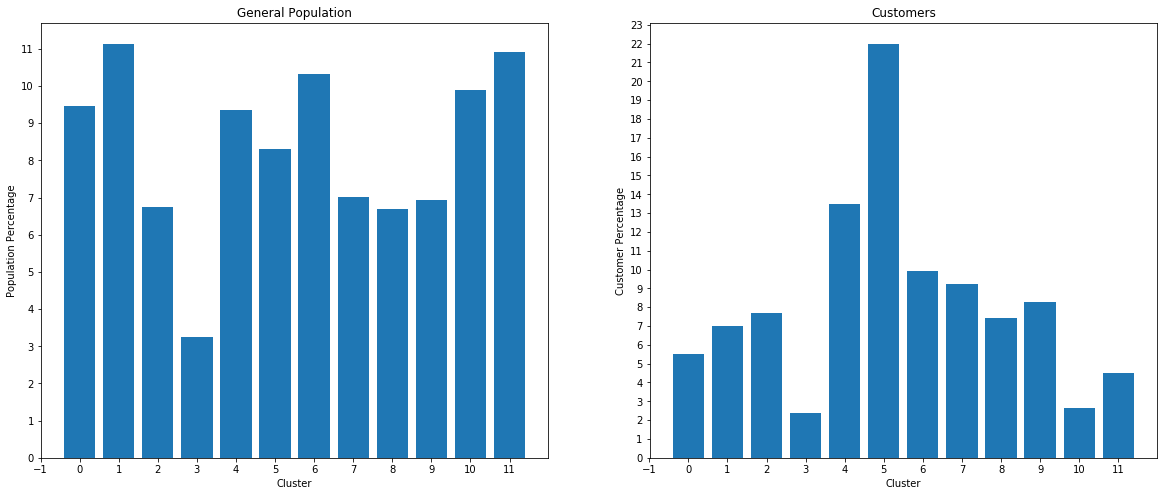

In [81]:
#plot the Demographics proportion of data points for each cluster and 
#Customers proportion of data points for each cluster.

plt.rcParams["figure.figsize"] = (20,8)
plt.subplot(1,2,1)
plt.title('General Population')
plt.ylabel('Population Percentage')
plt.xlabel('Cluster')
plt.xticks(np.arange(-1,12))
plt.yticks(np.arange(0,30,1))
plt.bar(list(az_dict.keys()),list(az_dict.values()))

plt.subplot(1,2,2)
plt.title('Customers')
plt.ylabel('Customer Percentage')
plt.xlabel('Cluster')
plt.yticks(np.arange(0,30,1))
plt.xticks(np.arange(-1,12))
plt.bar(list(cust_dict.keys()),list(cust_dict.values()))

plt.show()

In [73]:
#Function to calculate the centroid for defined cluster
def calc_centroid(cluster):
    centroid = scaler.inverse_transform(pca.inverse_transform(model.cluster_centers_[cluster]))
    
    center_dict = {}
    i=0

    for e in centroid:
        center_dict.update({azdias.columns[i]:e})
        i += 1
        if i == len(azdias.columns):
            break
    return center_dict

In [80]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Calculate centroid for cluster 5 which has approximately over 22% representation in the 
#customer data and only approximately 8.5% representation in the population data.

cent_dict_over = calc_centroid(5) #get dict of centroid for defined cluster
pprint.pprint(cent_dict_over)

{'ALTERSKATEGORIE_GROB': 1.7441198114950294,
 'ANREDE_KZ': 1.5392737952112856,
 'ANZ_HAUSHALTE_AKTIV': 3.0092261309359634,
 'ANZ_HH_TITEL': 3.0085948569824961,
 'ANZ_PERSONEN': 6.0028947329244984,
 'ANZ_TITEL': 5.9775080811702663,
 'ARBEIT': 3.0082109693595371,
 'BALLRAUM': 3.0161770975073008,
 'DECADE': 3.0063661602472322,
 'EWDICHTE': 3.0109578406827988,
 'FINANZ_ANLEGER': 4.9957129071247461,
 'FINANZ_HAUSBAUER': 2.9968325730736316,
 'FINANZ_MINIMALIST': 2.991812353538625,
 'FINANZ_SPARER': 3.9971895224060168,
 'FINANZ_UNAUFFAELLIGER': 4.9843214761438448,
 'FINANZ_VORSORGER': 2.9960167043946688,
 'GEBAEUDETYP_RASTER': 3.0117664638061905,
 'GREEN_AVANTGARDE_0': 3.0039143217413891,
 'GREEN_AVANTGARDE_1': 3.0088611763172044,
 'HEALTH_TYP': 4.6485892107791642,
 'HH_EINKOMMEN_SCORE': 5.0023012469376837,
 'INNENSTADT': 3.0025505736471105,
 'KBA05_ANTG1': 2.9555231271567939,
 'KBA05_ANTG2': 3.0254065202775862,
 'KBA05_ANTG3': 3.008307876173109,
 'KBA05_ANTG4': 26.640483367763863,
 'KBA05_GB

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Calculate centroid for cluster 10 which has approximately 2.6% representation in the 
#customer data and only approximately 9.9% representation in the population data.

cent_dict_under = calc_centroid(10) #get dict of centroid for defined cluster
pprint.pprint(cent_dict_under)

{'ALTERSKATEGORIE_GROB': 3.4245139944282537,
 'ANREDE_KZ': 1.3447491210877764,
 'ANZ_HAUSHALTE_AKTIV': 2.0514311112616079,
 'ANZ_HH_TITEL': 0.44500411868566586,
 'ANZ_PERSONEN': 3.6767523004998424,
 'ANZ_TITEL': 3.8473002901024351,
 'ARBEIT': 3.5439578803125036,
 'BALLRAUM': 3.5513471945857331,
 'DECADE': 3.2657842051548132,
 'EWDICHTE': 3.5550927198408715,
 'FINANZ_ANLEGER': 2.0919726162826775,
 'FINANZ_HAUSBAUER': 1.8530235457915027,
 'FINANZ_MINIMALIST': 4.5496271391133289,
 'FINANZ_SPARER': 1.6170435996663712,
 'FINANZ_UNAUFFAELLIGER': 2.9710389590533732,
 'FINANZ_VORSORGER': 4.4884577996018225,
 'GEBAEUDETYP_RASTER': 3.4378896522614184,
 'GREEN_AVANTGARDE_0': 3.5393777529814345,
 'GREEN_AVANTGARDE_1': 3.6048131945128206,
 'HEALTH_TYP': 1430.9593302011338,
 'HH_EINKOMMEN_SCORE': 4.0469072524469247,
 'INNENSTADT': 3.7694136813713133,
 'KBA05_ANTG1': 4.0769186406921083,
 'KBA05_ANTG2': 2.3596033403810148,
 'KBA05_ANTG3': 2.8689938298242978,
 'KBA05_ANTG4': 847.02986710888229,
 'KBA05

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

My clustering analysis revealed that people in the cluster #5 customer base seem to be the most popular target audience for the company while the cluster #10 customer base seems to be the least popular target audience.

Cluster #5 represents predominately younger life stage females. They tend to be younger, larger families with lower income. They tend to be socially minded people who tend to live in more densely populated areas. 

Cluster #10 represents younger males. They tend tend to be younger families, less affulent households, and are not interested in finance and investing. They tend to be very interested in saving money rather than spending money.

Based on the analysis, it seems that the company should target their female customer base as they tend to be more likely willing to shop compared to their male customer base.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.